In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mppi import InputFiles as I, Calculators as C, Datasets as D

In [2]:
omp = 1
mpi_run = 'mpirun -np 16'

# Nscf on a grid - Ypp bands

In this nb we perform (several) nscf computation on a regular grid and reproduce the ks bands using ypp. In this way we can perform a check on the dimension of the k grid that will be used in the subsequent yambo real time computations. 

This framework allows us also to use yambo scissor to open the ks band-gap.

We also include the presence of a shift in the k-points sampling. We will then compare the ip absorption spectrum obtained with the various sampling the understand which sampling is needed to obtain reliable results in the RT analysis

## Nscf on a regular grid

We define the basic elements of the input

In [3]:
input = I.PwIn()
Ga = [0.,0.,0.]
As = [0.25,0.25,0.25]

input.set_pseudo_dir('../pseudos')
input.set_calculation('nscf')

input.set_occupations('fixed')
input.system['ibrav'] = 2
input.system['celldm(1)'] = 10.677
input.system['noncolin'] = '.true'
input.system['lspinorb'] = '.true'
input.set_atoms_type(2)
input.set_atoms_number(2)
input.set_atoms_position(pos_type='crystal',pos_list=[['Ga',Ga],['As',As]])
input.atypes = {'Ga': [69.72,'Ga_rel.pz-rrkj3.UPF'],\
                'As': [74.92,'As_rel.pz-rrkj3.UPF']}
input.set_convergence_thr(1e-8)

On this basis of the gs_convergence analysis previously performed we choose the scf converged parameters:

In [4]:
k_conv = 6
ecut_conv = 80

and we perform the nscf computations using a number of bands given by:

In [5]:
numBands = 40

In [6]:
code = C.QeCalculator(omp=omp,mpi_run=mpi_run,executable='pw.x',verbose=True,skip=True)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 16 pw.x


We perform nscf computation on grids of various dimensions. The simulations are organized in a dataset

In [7]:
nscf_kvalues = [4,6,8,10,12,20]

In [8]:
bnds_study = D.Dataset(label='nscf',run_dir='nscf',pre_processing='nscf')

In [9]:
input.system['nbnd'] = numBands
for k  in nscf_kvalues:
    idd = {'bnds' : numBands, 'kpoints' : k} 
    input.set_prefix(D.name_from_id(idd))
    input.set_energy_cutoff(ecut_conv)
    input.set_kpoints(ktype='automatic',kpoints=[k,k,k])
    bnds_study.append_run(id=idd,calculator=code,input=input)

Apply the pre-processing

In [10]:
source = 'gs_convergence/ecut_%s-k_%s.save'%(ecut_conv,k_conv)

In [11]:
bnds_study.pre_processing_function(source_dir=source)

Folder nscf already exists
nscf .save folder exsists. gs_convergence/ecut_80-k_6.save not copied
nscf .save folder exsists. gs_convergence/ecut_80-k_6.save not copied
nscf .save folder exsists. gs_convergence/ecut_80-k_6.save not copied
nscf .save folder exsists. gs_convergence/ecut_80-k_6.save not copied
nscf .save folder exsists. gs_convergence/ecut_80-k_6.save not copied
execute :  cp -r gs_convergence/ecut_80-k_6.save nscf/bnds_40-kpoints_20.save


In [12]:
bnds_study.run()

skip the computation for : bnds_40-kpoints_4.in
parse file : nscf/bnds_40-kpoints_4.save/data-file-schema.xml
skip the computation for : bnds_40-kpoints_6.in
parse file : nscf/bnds_40-kpoints_6.save/data-file-schema.xml
skip the computation for : bnds_40-kpoints_8.in
parse file : nscf/bnds_40-kpoints_8.save/data-file-schema.xml
skip the computation for : bnds_40-kpoints_10.in
parse file : nscf/bnds_40-kpoints_10.save/data-file-schema.xml
skip the computation for : bnds_40-kpoints_12.in
parse file : nscf/bnds_40-kpoints_12.save/data-file-schema.xml
execute : cd nscf ; OMP_NUM_THREADS=1 mpirun -np 16 pw.x -inp bnds_40-kpoints_20.in > bnds_40-kpoints_20.log
parse file : nscf/bnds_40-kpoints_20.save/data-file-schema.xml


We also perform some computations with shifted grids

In [13]:
numBands = 40
nscf_kvalues = [8,10,12]
s = [1,1,1]

In [14]:
shift = D.Dataset(label='nscf',run_dir='nscf',pre_processing='nscf')

In [15]:
input.system['nbnd'] = numBands
for k  in nscf_kvalues:
    idd = {'bnds' : numBands, 'kpoints' : k, 'shift' : 1} 
    input.set_prefix(D.name_from_id(idd))
    input.set_energy_cutoff(ecut_conv)
    input.set_kpoints(ktype='automatic',kpoints=[k,k,k],shiftk=s)
    shift.append_run(id=idd,calculator=code,input=input)

In [16]:
source = 'gs_convergence/ecut_%s-k_%s.save'%(ecut_conv,k_conv)
shift.pre_processing_function(source_dir=source)

Folder nscf already exists
nscf .save folder exsists. gs_convergence/ecut_80-k_6.save not copied
nscf .save folder exsists. gs_convergence/ecut_80-k_6.save not copied
nscf .save folder exsists. gs_convergence/ecut_80-k_6.save not copied


In [17]:
shift.run()

skip the computation for : bnds_40-kpoints_8-shift_1.in
parse file : nscf/bnds_40-kpoints_8-shift_1.save/data-file-schema.xml
skip the computation for : bnds_40-kpoints_10-shift_1.in
parse file : nscf/bnds_40-kpoints_10-shift_1.save/data-file-schema.xml
skip the computation for : bnds_40-kpoints_12-shift_1.in
parse file : nscf/bnds_40-kpoints_12-shift_1.save/data-file-schema.xml


Setup the nscf on a random grids in the region close to Gamma

In [18]:
import random as rand
numBands = 40
num_kpoints = 100
k_span = 0.1
weight = 1.

In [19]:
klist = []
for n in range(num_kpoints):
    k_rand = [k_span*(rand.random()-0.5) for ind in range(3)] + [weight]
    klist.append(k_rand)

In [20]:
random_study = D.Dataset(label='nscf',run_dir='nscf',pre_processing='nscf')

In [21]:
input.system['nbnd'] = numBands
idd = {'bnds' : numBands, 'kpoints' : num_kpoints, 'sampling' : 'random'} 
input.set_prefix(D.name_from_id(idd))
input.set_energy_cutoff(ecut_conv)
input.set_kpoints(ktype='tpiba',klist=klist)
random_study.append_run(id=idd,calculator=code,input=input)

In [23]:
#print(random_study.runs[0])

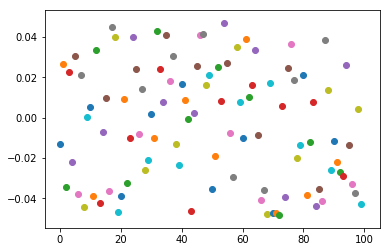

In [24]:
for ind,k in enumerate(klist):
    plt.scatter(ind,k[0])

Apply the pre-processing

In [25]:
source = 'gs_convergence/ecut_%s-k_%s.save'%(ecut_conv,k_conv)

In [26]:
random_study.pre_processing_function(source_dir=source)

Folder nscf already exists
execute :  cp -r gs_convergence/ecut_80-k_6.save nscf/bnds_40-kpoints_100-sampling_random.save


In [27]:
random_study.run()

execute : cd nscf ; OMP_NUM_THREADS=1 mpirun -np 16 pw.x -inp bnds_40-kpoints_100-sampling_random.in > bnds_40-kpoints_100-sampling_random.log
parse file : nscf/bnds_40-kpoints_100-sampling_random.save/data-file-schema.xml


Setup the nscf on a regular grids in the region close to Gamma

In [16]:
kmin = -0.05
kmax = 0.05
num_kpoints = 11
numBands = 40
weight = 1.
linear_sampling = np.linspace(kmin,kmax,num_kpoints)
print(linear_sampling)

[-0.05 -0.04 -0.03 -0.02 -0.01  0.    0.01  0.02  0.03  0.04  0.05]


In [17]:
klist = []
for x in linear_sampling:
    for y in linear_sampling:
        for z in linear_sampling:
            klist.append([x,y,z,weight])

In [18]:
#klist

In [19]:
regular = D.Dataset(label='nscf',run_dir='nscf',pre_processing='nscf')

In [20]:
input.system['nbnd'] = numBands
idd = {'bnds' : numBands, 'kpoints' : num_kpoints, 'sampling' : 'reg_grid'} 
input.set_prefix(D.name_from_id(idd))
input.set_energy_cutoff(ecut_conv)
input.set_kpoints(ktype='tpiba',klist=klist)
regular.append_run(id=idd,calculator=code,input=input)

Apply the pre-processing

In [21]:
source = 'gs_convergence/ecut_%s-k_%s.save'%(ecut_conv,k_conv)

In [22]:
regular.pre_processing_function(source_dir=source)

Folder nscf already exists
nscf .save folder exsists. gs_convergence/ecut_80-k_6.save not copied


In [23]:
regular.run()

skip the computation for : bnds_40-kpoints_11-sampling_reg_grid.in
parse file : nscf/bnds_40-kpoints_11-sampling_reg_grid.save/data-file-schema.xml


## Energy gap for each k

In [20]:
results = bnds_study.fetch_results(id={'kpoints' : 20})[0]
bands = results.band_structure(plot=False)
k_values = bands[:,0] # position on the path
kpoints_cart = results.kpt_cart # cartesian position for each value on the path

In [21]:
gap = 1.0+bands[:,9]-bands[:,7]
for ind in range(len(k_values)):
    if gap[ind] < 2.0: print(kpoints_cart[ind],gap[ind])

[0. 0. 0.] 1.41800629710374
[-0.05  0.05 -0.05] 1.9710532670491938


In [30]:
results_shift = shift.fetch_results(id={'kpoints' : 8})[0]
bands_shift = results_shift.band_structure(plot=False)
k_values_shift = bands_shift[:,0] # position on the path
kpoints_cart_shift = results_shift.kpt_cart # cartesian position for each value on the path

In [31]:
gap = 1.0+bands_shift[:,9]-bands_shift[:,7]
for ind in range(len(k_values_shift)):
    if gap[ind] < 3.0: print(kpoints_cart_shift[ind],gap[ind])

[-0.0625  0.0625  0.0625] 2.1325879471696867
[-0.1875  0.1875  0.1875] 2.9370784378585446
[-0.3125  0.3125  0.3125] 2.9716582089123897
[-0.4375  0.4375  0.4375] 2.9450956434459306


In [32]:
results_shift = shift.fetch_results(id={'kpoints' : 10})[0]
bands_shift = results_shift.band_structure(plot=False)
k_values_shift = bands_shift[:,0] # position on the path
kpoints_cart_shift = results_shift.kpt_cart # cartesian position for each value on the path

In [33]:
gap = 1.0+bands_shift[:,9]-bands_shift[:,7]
for ind in range(len(k_values_shift)):
    if gap[ind] < 3.0: print(kpoints_cart_shift[ind],gap[ind])

[-0.05  0.05  0.05] 1.9710532670493324
[-0.15  0.15 -0.05] 2.8355904635182974
[ 0.05 -0.05  0.15] 2.7628082763269193
[-0.15  0.15  0.15] 2.8425594096297697
[-0.25  0.25  0.25] 2.978692997310417
[-0.35  0.35  0.35] 2.9624473557927127
[-0.45  0.45  0.45] 2.943655187656332


In [34]:
results_shift = shift.fetch_results(id={'kpoints' : 12})[0]
bands_shift = results_shift.band_structure(plot=False)
k_values_shift = bands_shift[:,0] # position on the path
kpoints_cart_shift = results_shift.kpt_cart # cartesian position for each value on the path

In [35]:
gap = 1.0+bands_shift[:,9]-bands_shift[:,7]
for ind in range(len(k_values_shift)):
    if gap[ind] < 3.0: print(kpoints_cart_shift[ind],gap[ind])

[-0.04166667  0.04166667  0.04166667] 1.8592888075624767
[-0.125       0.125      -0.04166667] 2.6469310284565397
[ 0.04166667 -0.04166667  0.125     ] 2.5094383193863594
[-0.125  0.125  0.125] 2.7219525960920343
[-0.20833333  0.20833333  0.20833333] 2.9614092776986647
[-0.29166667  0.29166667  0.29166667] 2.9759930402493806
[-0.375  0.375  0.375] 2.9564558444497906
[-0.45833333  0.45833333  0.45833333] 2.9428648209594948


This charts evidences that for each choice of kpoints (both shifted or not) there is actually only one k-point
with a energy gap in the interesting range. In this way we cannot expect to sample different spin region with a scan of the frequency of the probe. We have to enrich the k sampling in order to capture all the points that gives an energy gap that can be excited in our frequency range.

This can be done by performing a random sampling in a region of the BZ close to the Gamma point. Here we have performed random sampling in a cube of size 0.1 centred on Gamma. All the sampled points give rises to energy gap lower than 2 eV.

In [36]:
results_random = random_study.fetch_results(id={'kpoints' : 100})[0]
bands_random = results_random.band_structure(plot=False)
k_values_random = bands_random[:,0] # position on the path
kpoints_cart_random = results_random.kpt_cart # cartesian position for each value on the path

In [39]:
gap1 = 1.0+bands_random[:,9]-bands_random[:,7]
gap2 = 1.0+bands_random[:,10]-bands_random[:,8]
gap3 = 1.0+bands_random[:,9]-bands_random[:,8]

for ind in range(len(k_values_random)):
    if gap1[ind] < 2.0: print(ind, kpoints_cart_random[ind],gap[ind],gap2[ind],gap3[ind])

0 [-0.01278642  0.00131419 -0.03692028] 1.6174884133908352 1.6187159742076593 1.6172194531813773
1 [ 0.02646098 -0.00891092  0.01116283] 1.5452834230252854 1.5461205318800193 1.5452364160705203
2 [-0.03430158  0.04715978 -0.03309002] 1.8218258972240413 1.8241301799787486 1.8216675505819548
3 [ 0.02255488  0.01187188 -0.04076938] 1.6813611101770833 1.683602298001281 1.6809516347278333
4 [-0.02191683  0.03331801  0.02740873] 1.6752960998589552 1.6766075047316935 1.6752122172381938
5 [ 0.0304125  -0.04032259 -0.04328747] 1.8162364496487422 1.8183716472925457 1.8160589255505988
6 [-0.03792962 -0.02790043  0.04401596] 1.8010371099866722 1.8034411366313945 1.8007947862863505
7 [ 0.0210096  -0.00859063  0.02189669] 1.5523056754385793 1.5533332026741649 1.5521973990694793
8 [-0.0440291   0.02304338  0.00459638] 1.7001517321774529 1.7025874370621334 1.6994221799201599
9 [ 0.00040031  0.01577874 -0.04296778] 1.672154516117339 1.6738456815331357 1.671689650843863
10 [ 0.00511147  0.04764649 -0.04

So we expect that all these points contribute to the neq occupation in the presence of a pump in the frequency range in which we are interested in.

Check the results also for the regular grid close to Gamma

In [24]:
results_regular = regular.fetch_results(id={'kpoints' : 11})[0]
bands_regular = results_regular.band_structure(plot=False)
k_values_regular = bands_regular[:,0] # position on the path
kpoints_cart_regular = results_regular.kpt_cart # cartesian position for each value on the path

In [28]:
gap1 = 1.0+bands_regular[:,9]-bands_regular[:,7]
gap2 = 1.0+bands_regular[:,10]-bands_regular[:,8]
gap3 = 1.0+bands_regular[:,9]-bands_regular[:,8]

for ind in range(len(k_values_regular)):
    if gap1[ind] < 2.0: print(ind, kpoints_cart_regular[ind],gap1[ind],gap2[ind],gap3[ind])

0 [-0.05 -0.05 -0.05] 1.9710532670489753 1.971053267049009 1.9710532670486955
1 [-0.05 -0.05 -0.04] 1.930393157694824 1.9326016400619572 1.930238928615415
2 [-0.05 -0.05 -0.03] 1.899325916076127 1.9031565014393053 1.898727144768455
3 [-0.05 -0.05 -0.02] 1.8776416115813541 1.8824824150713102 1.8764347953706206
4 [-0.05 -0.05 -0.01] 1.8649149436734591 1.8702569385115098 1.8631753270898983
5 [-0.05 -0.05  0.  ] 1.860730103277196 1.8662153257230853 1.8587778784834246
6 [-0.05 -0.05  0.01] 1.8649149436737709 1.8702569385112442 1.8631753270895848
7 [-0.05 -0.05  0.02] 1.8776416115824128 1.8824824150712178 1.8764347953703568
8 [-0.05 -0.05  0.03] 1.8993259160761564 1.9031565014392449 1.898727144768479
9 [-0.05 -0.05  0.04] 1.9303931576944668 1.9326016400616393 1.930238928614501
10 [-0.05 -0.05  0.05] 1.9710532670481085 1.971053267048851 1.9710532670476626
11 [-0.05 -0.04 -0.05] 1.9303931576935378 1.9326016400623134 1.930238928613564
12 [-0.05 -0.04 -0.04] 1.8862903941801887 1.8882793198669372

265 [-0.03 -0.03 -0.04] 1.7521393898903215 1.753695437213194 1.7520595633515317
266 [-0.03 -0.03 -0.03] 1.7017506815154881 1.7017506815159482 1.7017506815154233
267 [-0.03 -0.03 -0.02] 1.663734887041679 1.6650809127472206 1.6636369144369327
268 [-0.03 -0.03 -0.01] 1.6409097571853728 1.643032849994265 1.6405712655258409
269 [-0.03 -0.03  0.  ] 1.6333771253275176 1.6357294337997512 1.6328976631744618
270 [-0.03 -0.03  0.01] 1.6409097571856037 1.6430328499947748 1.6405712655267175
271 [-0.03 -0.03  0.02] 1.6637348870421915 1.6650809127470207 1.6636369144374266
272 [-0.03 -0.03  0.03] 1.7017506815165495 1.70175068151661 1.7017506815164545
273 [-0.03 -0.03  0.04] 1.752139389890555 1.753695437213505 1.7520595633516356
274 [-0.03 -0.03  0.05] 1.8145959104279683 1.8176313282066854 1.814338939053851
275 [-0.03 -0.02 -0.05] 1.7884261002595974 1.7917000658665883 1.7878598975650792
276 [-0.03 -0.02 -0.04] 1.7200717967120225 1.7223604496064233 1.7197868035483648
277 [-0.03 -0.02 -0.03] 1.6637348870

562 [-0.01  0.02 -0.04] 1.6652969215097269 1.6673280353335205 1.664922297053094
563 [-0.01  0.02 -0.03] 1.5959447288142483 1.5973567648444922 1.5957528946366963
564 [-0.01  0.02 -0.02] 1.541442191815193 1.5422330474705355 1.541377929742012
565 [-0.01  0.02 -0.01] 1.5067302845639627 1.5072078737866796 1.5067130711168781
566 [-0.01  0.02  0.  ] 1.4950958965191194 1.4955711334505688 1.4950246585551366
567 [-0.01  0.02  0.01] 1.5067302845637114 1.5072078737870873 1.5067130711165513
568 [-0.01  0.02  0.02] 1.5414421918153698 1.5422330474707735 1.541377929743077
569 [-0.01  0.02  0.03] 1.5959447288149127 1.597356764844581 1.5957528946373447
570 [-0.01  0.02  0.04] 1.6652969215087277 1.667328035333207 1.6649222970522368
571 [-0.01  0.02  0.05] 1.7453770894115523 1.747967760487497 1.7448071477138187
572 [-0.01  0.03 -0.05] 1.7731101950721264 1.7764756032012663 1.7720576860119968
573 [-0.01  0.03 -0.04] 1.7010072112629029 1.7038161479701541 1.7003762752006146
574 [-0.01  0.03 -0.03] 1.640909757

858 [ 0.02 -0.04 -0.05] 1.8273818879433419 1.8313038784353726 1.8265113960123474
859 [ 0.02 -0.04 -0.04] 1.76771042348049 1.7707533986627384 1.7672279225963425
860 [ 0.02 -0.04 -0.03] 1.720071796711994 1.7223604496064366 1.7197868035483665
861 [ 0.02 -0.04 -0.02] 1.6856634994975117 1.6877721026826844 1.6855272617256025
862 [ 0.02 -0.04 -0.01] 1.6652969215084852 1.667328035332745 1.664922297052156
863 [ 0.02 -0.04  0.  ] 1.6586497937212608 1.6606263249540865 1.6580918051051636
864 [ 0.02 -0.04  0.01] 1.6652969215099338 1.667328035332491 1.6649222970525095
865 [ 0.02 -0.04  0.02] 1.685663499497422 1.687772102683005 1.6855272617257384
866 [ 0.02 -0.04  0.03] 1.7200717967120385 1.7223604496064988 1.719786803548348
867 [ 0.02 -0.04  0.04] 1.7677104234802261 1.7707533986626398 1.7672279225958505
868 [ 0.02 -0.04  0.05] 1.8273818879432282 1.831303878432788 1.8265113960106554
869 [ 0.02 -0.03 -0.05] 1.7884261002584383 1.7917000658669586 1.7878598975637026
870 [ 0.02 -0.03 -0.04] 1.720071796711

1286 [0.05 0.01 0.05] 1.8649149436730976 1.8702569385114485 1.8631753270893876
1287 [ 0.05  0.02 -0.05] 1.8776416115815753 1.8824824150709052 1.8764347953707237
1288 [ 0.05  0.02 -0.04] 1.8273818879429085 1.8313038784345537 1.8265113960115
1289 [ 0.05  0.02 -0.03] 1.7884261002591089 1.7917000658667597 1.787859897564383
1290 [ 0.05  0.02 -0.02] 1.7610577793004243 1.7641684149200296 1.7608512648602916
1291 [ 0.05  0.02 -0.01] 1.7453770894111145 1.747967760487617 1.7448071477133213
1292 [0.05 0.02 0.  ] 1.7403295719473206 1.742659017961441 1.7395113508644302
1293 [0.05 0.02 0.01] 1.7453770894124343 1.7479677604888826 1.7448071477143658
1294 [0.05 0.02 0.02] 1.761057779299831 1.764168414920002 1.7608512648602446
1295 [0.05 0.02 0.03] 1.7884261002583433 1.791700065867107 1.7878598975642372
1296 [0.05 0.02 0.04] 1.8273818879433437 1.8313038784352331 1.8265113960121262
1297 [0.05 0.02 0.05] 1.8776416115817467 1.882482415070684 1.8764347953702964
1298 [ 0.05  0.03 -0.05] 1.8993259160761404 1.9

also in this case all the point contribute

## Ypp bands

The band structure can be extracted from the nscf computation on a grid using ypp. 

For each choice of the nscf .save folder we have a different dataset (each of which will be composed by only one computation)

In [18]:
code = C.YamboCalculator(omp=1,mpi_run='mpirun -np 1',executable='ypp',suffix='bands_interpolated',skip=False)

Initialize a Yambo calculator with command OMP_NUM_THREADS=1 mpirun -np 1 ypp
Suffix for post_processing :  bands_interpolated


We organize the various datasets in a dictionary (is it possible to build a high hierarchy dataset?)

In [19]:
nscf_kvalues = [4,6,8,10,12] # to set the values for the non shifted grids

ypp = {}
for k in nscf_kvalues:
    string = 'ypp_bands_k%s'%k
    study = D.Dataset(label=string,run_dir=string,pre_processing='yambo')
    source = 'nscf/bnds_40-kpoints_%s.save'%k
    study.pre_processing_function(source_dir=source)
    ypp[k] = study

Create folder ypp_bands_k8
execute :  cd nscf/bnds_40-kpoints_8.save;p2y -a 2
execute :  cp -r nscf/bnds_40-kpoints_8.save/SAVE ypp_bands_k8
execute :  cd ypp_bands_k8;OMP_NUM_THREADS=1 yambo
Create folder ypp_bands_k10
execute :  cd nscf/bnds_40-kpoints_10.save;p2y -a 2
execute :  cp -r nscf/bnds_40-kpoints_10.save/SAVE ypp_bands_k10
execute :  cd ypp_bands_k10;OMP_NUM_THREADS=1 yambo


We build the input file and append the run to each dataset. The parameters of the path are given as

In [20]:
# in alat
G = [0.,0.,0.]
X = [1.,0.,0.]
L = [0.5,0.5,0.5]
W = [1.0,0.5,0.]
path = [L,G,X,W]

band_range = [1,12]
bands_step = 50

In [21]:
for k in ypp:
    ypp_input = I.YppIn('ypp -s b -V all ',folder=ypp[k].run_dir)
    input = ypp_input.getInput()
    # scissor
    input['GfnQP_E'] = [1.0,1.0,1.0]
    # band structure
    input['BANDS_steps'] = bands_step
    input['BANDS_bands'] = band_range
    input['BANDS_kpts'] = path
    input['cooIn'] = 'alat'
    input['cooOut'] = 'alat'
    
    idd = {'ypp_bands_k' : k}
    ypp[k].append_run(id=idd,calculator=code,input=ypp_input)

execute :  cd ypp_bands_k8; ypp -s b -V all  -F ypp.in
execute :  cd ypp_bands_k10; ypp -s b -V all  -F ypp.in


We can run all the datasets

In [22]:
for k in ypp:
    ypp[k].run()

execute :  cd ypp_bands_k8; ypp -s b -V all  -F ypp_bands_k_8.in
execute : cd ypp_bands_k8 ; OMP_NUM_THREADS=1 mpirun -np 1 ypp -F ypp_bands_k_8.in -J ypp_bands_k_8 -C ypp_bands_k_8
parse file : ypp_bands_k8/ypp_bands_k_8/o-ypp_bands_k_8.bands_interpolated
execute :  cd ypp_bands_k10; ypp -s b -V all  -F ypp_bands_k_10.in
execute : cd ypp_bands_k10 ; OMP_NUM_THREADS=1 mpirun -np 1 ypp -F ypp_bands_k_10.in -J ypp_bands_k_10 -C ypp_bands_k_10
parse file : ypp_bands_k10/ypp_bands_k_10/o-ypp_bands_k_10.bands_interpolated


We compare the band structure obtained in the various datasets

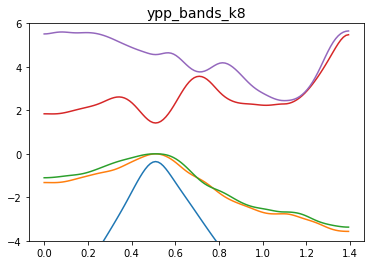

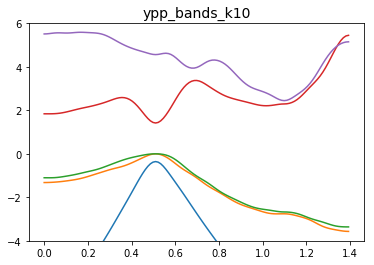

In [23]:
for k,y in ypp.items():
    kvalues = y.fetch_results(attribute='k')[0]
    bands = []
    for ind in range(1,13):
        bands.append(y.fetch_results(attribute='b%s'%ind)[0])
    for bnd in [3,5,7,9,11]:
        plt.plot(kvalues,bands[bnd])
    plt.title(y.label,size=14)
    plt.ylim((-4,6))
    plt.show()

Comparing this plots we see that the band structure seems (quite) well converged at k=8

We can identify the Gamma point on the path and compute the direct band gap for the various cases. The path is the same in all the computations so the identification of Gamma can be done only one time

In [26]:
kvalues = ypp[8].fetch_results(attribute='k')[0]
for ind,k in enumerate(kvalues):
    kx = ypp[8].fetch_results(attribute='k_x')[0][ind]
    ky = ypp[8].fetch_results(attribute='k_y')[0][ind]
    kz = ypp[8].fetch_results(attribute='k_z')[0][ind]
    if kx == 0. and ky == 0. and kz == 0.:
        gamma_position = ind
gamma_position

43

In [27]:
for k,y in ypp.items():
    kvalues = y.fetch_results(attribute='k')[0]
    bands = []
    for ind in range(1,13):
        bands.append(y.fetch_results(attribute='b%s'%ind)[0])
    Delta = bands[8][gamma_position]-bands[7][gamma_position]
    print('Gap for k = ',k,' : ','%.4f'%Delta)

Gap for k =  8  :  1.4181
Gap for k =  10  :  1.4180


We can also plot the quantities reported in other files, for instance

In [28]:
fname = 'ypp_bands_k8/ypp_bands_k_8/o-ypp_bands_k_8.magnetization_y'

In [29]:
res = C.dict_parser(fname)

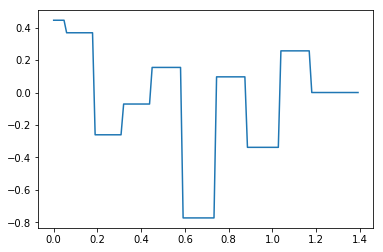

In [30]:
kvalues = res['k']
bands = []
for ind in range(1,13):
    b = 'b%s'%ind
    bands.append(res[b])
for bnd in [7]:
    plt.plot(kvalues,bands[bnd])

plt.show()